## Notebook Purpose

Evaluate output of original fastmri (pytorch=1.5) vs new fastmri (pytorch=1.7) to see if output is the same


# CURRENT STATUS

- running over a range of different scaling factors
    - simultaneously doing this with original fastmri and new fastmri
- does changing the scaling factor mitigates artifacts in some cases?
    - preliminary yes
- is one scaling factor universally better? or does it depend on image characteristics?
    - preliminary no, yes
- which scaling factors perform well on different characteristics of images?
- do these same results hold for the old repo?

## TODO

- verify code below for printing doesn't have bugs, i.e. it's printing the right stuff
- try to answer the questions above
- run for old repo

## THEN
- once analysis is done -- unless i have a clear answer... keep both repos, make thorough notes, and move on. this ultimately won't matter for near-term goals i.e. giving a presentation on work

In [22]:
import os, sys
from os import listdir
from os.path import isfile, join
import numpy as np
import torch
from matplotlib import pyplot as plt

sys.path.append('/home/vanveen/ConvDecoder/')
from utils.evaluate import calc_metrics, normalize_img

In [107]:
if None:
    print('x')

In [121]:
def plot_list(arr_list, title_list=None):
    
    NUM_COLS = len(arr_list)
#     if not title_list:
#         title_list = ['ground-truth', 'old', 'new', 'x']
    
    fig = plt.figure(figsize=(20,20))
    
    for idx in range(NUM_COLS):
        ax = fig.add_subplot(1,NUM_COLS,idx+1)
        ax.imshow(arr_list[idx], cmap='gray')
        ax.set_title(title_list[idx], fontsize=20)
        ax.axis('off')
    plt.show()

In [63]:
path_o = '/bmrNAS/people/dvv/out_fastmri/old_pytorch1.5/'
path_n = '/bmrNAS/people/dvv/out_fastmri/new_pytorch1.7/norm_ortho/'

def get_files(path):
    files = [f for f in listdir(path) if isfile(join(path, f))]
    files.sort()
    return files

files_o = [f for f in get_files(path_o) if 'iter10000_alpha0.npy' in f]
files_n_dc = [f for f in get_files(path_n) if '_dc.npy' in f]

In [84]:
files_n_dc[:8]

['1000007_dc.npy',
 '1000273_dc.npy',
 '1000325_dc.npy',
 '1000464_dc.npy',
 '1000537_dc.npy',
 '1000818_dc.npy',
 '1001140_dc.npy',
 '1001219_dc.npy']

In [78]:
vid_key = '1000007'
vid_key = '1000464'

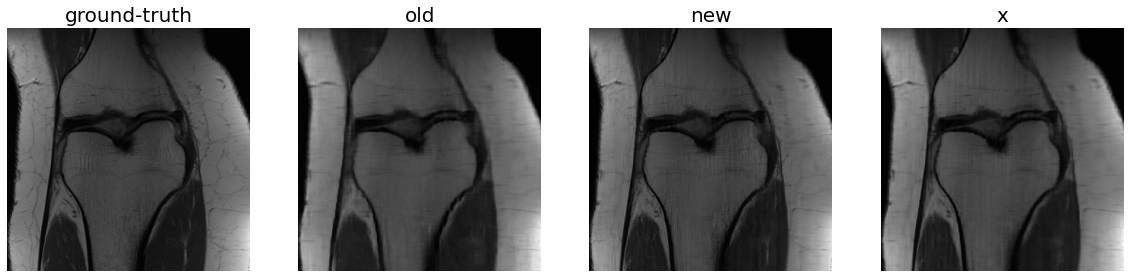

(0.7220112873131161, None, 0.8550107647124398, 33.36851266138021)
(0.8219204686088788, None, 0.8834538872142929, 35.66263392075007)
(0.802638382313297, None, 0.88117937631323, 35.2895196012119)


In [79]:
path_n_ca = '/bmrNAS/people/dvv/out_fastmri/new_pytorch1.7/not_halved/'
path_n_no = path_n

# vid_key = '1000007'
arr_o = np.load('{}{}_iter10000_alpha0.npy'.format(path_o, vid_key))
arr_gt = np.load('{}{}_gt.npy'.format(path_n_ca, vid_key))
arr_n_ca = np.load('{}{}_dc.npy'.format(path_n_ca, vid_key))
arr_n_no = np.load('{}{}_dc.npy'.format(path_n_no, vid_key))

plot_list([arr_gt, arr_o, arr_n_ca, arr_n_no])

print(calc_metrics(arr_gt, arr_o))
print(calc_metrics(arr_gt, arr_n_ca))
print(calc_metrics(arr_gt, arr_n_no))

1000007
old__ ssim: 0.405, psnr 24.0
best_ ssim: 0.417, psnr 23.928
worst ssim: 0.241, psnr 19.635


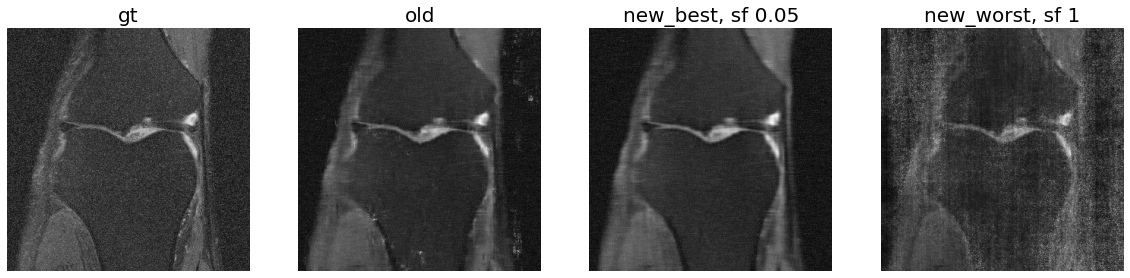

1000273
old__ ssim: 0.752, psnr 31.0
best_ ssim: 0.76, psnr 31.526
worst ssim: 0.662, psnr 29.605


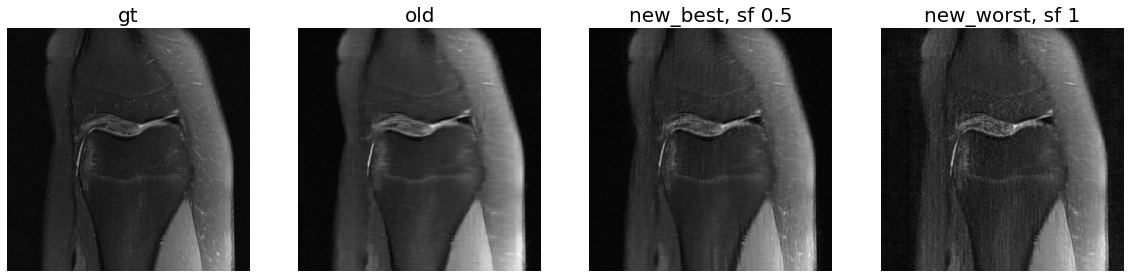

1000325
old__ ssim: 0.764, psnr 32.0
best_ ssim: 0.779, psnr 32.78
worst ssim: 0.641, psnr 27.431


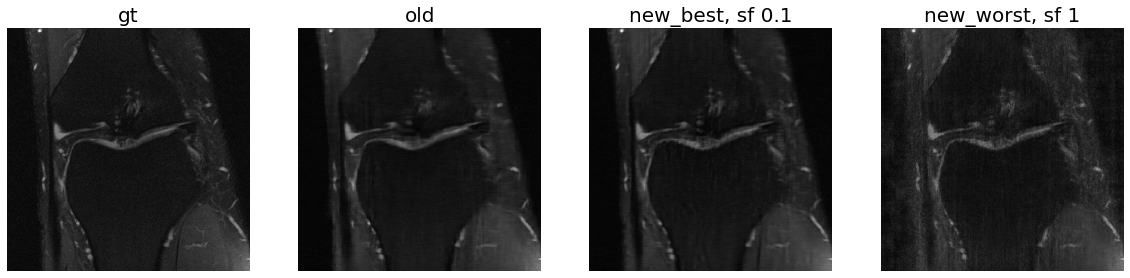

1000464
old__ ssim: 0.842, psnr 33.0
best_ ssim: 0.88, psnr 35.497
worst ssim: 0.802, psnr 29.906


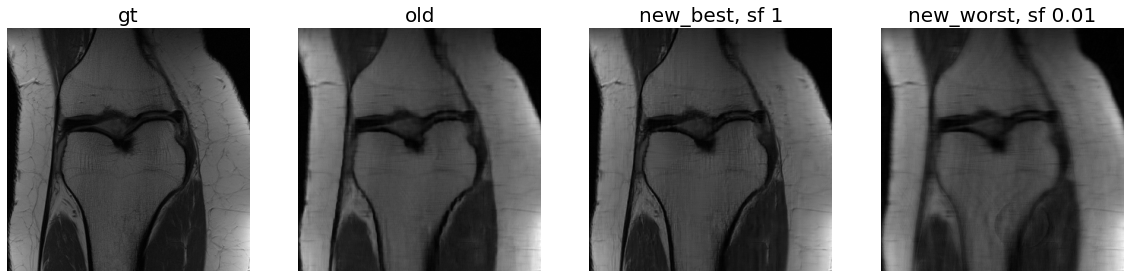

1000537
old__ ssim: 0.797, psnr 31.0
best_ ssim: 0.825, psnr 32.922
worst ssim: 0.762, psnr 28.783


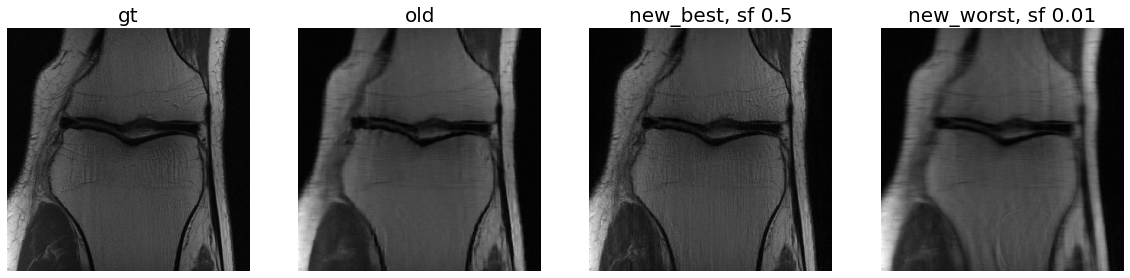

1000818
old__ ssim: 0.788, psnr 32.0
best_ ssim: 0.787, psnr 32.372
worst ssim: 0.647, psnr 27.34


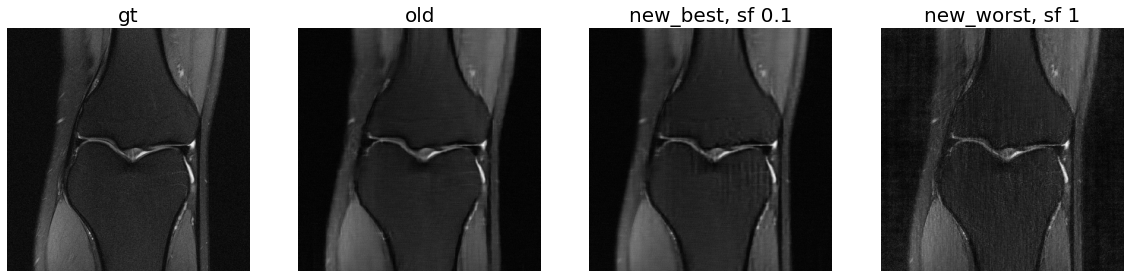

1001140
old__ ssim: 0.753, psnr 31.0
best_ ssim: 0.77, psnr 31.82
worst ssim: 0.655, psnr 29.548


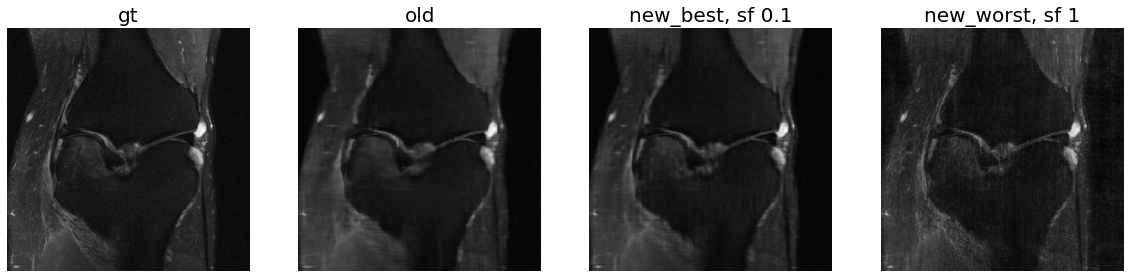

1001219
old__ ssim: 0.858, psnr 34.0
best_ ssim: 0.88, psnr 35.485
worst ssim: 0.836, psnr 32.493


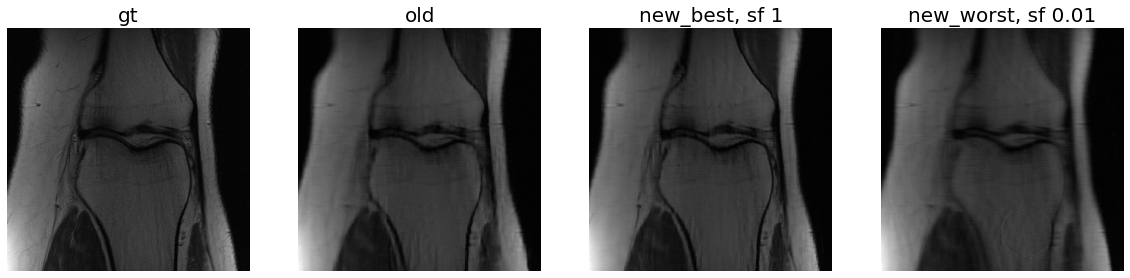

In [155]:
sf_list = ['1', '0.5', '0.1', '0.05', '0.01']
title_list = ['old'] + sf_list
path_sfs = '/bmrNAS/people/dvv/out_fastmri/new_pytorch1.7/'

NUM_VARS = len(sf_list) + 1 # all sf variants plus pt==1.5 version
DIM = 320 # size of square img
arr_list = np.empty((NUM_VARS, DIM, DIM))
arr_plot_list = np.empty(())

for f in files_n_dc[:8]:
    
    ssim_list, psnr_list = [], []
    
    vid_key = f.split('_')[0]
    
    arr_gt = np.load('{}sf1/{}_gt.npy'.format(path_sfs, vid_key))#[None,:]
    arr_o = np.load('{}{}_iter10000_alpha0.npy'.format(path_o, vid_key))#[None,:]
    arr_list[0] = arr_o
        
    for idx_sf, sf in enumerate(sf_list):
        arr_sf = np.load('{}sf{}/{}_dc.npy'.format(path_sfs, sf, vid_key))#[None,:]
        arr_list[idx_sf+1] = arr_sf # offset of 1 b/c old pt==1.5 version already in place
        
    # calc metrics
    for idx, arr in enumerate(arr_list):
        _, _, ssim_, psnr_ = calc_metrics(arr, arr_gt)#[0])
#         print('{}, {}: ssim {}, psnr {}'.format(vid_key, title_list[idx], \
#                                 np.round(ssim_, 3), np.round(psnr_, 3)))
        ssim_list.append(ssim_), psnr_list.append(psnr_)
    ssim_list, psnr_list = np.array(ssim_list), np.array(psnr_list)
        
    # get best/worst recon of sfs, i.e. must remove old but maintain idx integrity
    idx_max_ssim, idx_max_psnr = np.argmax(ssim_list[1:]) + 1, np.argmax(psnr_list[1:]) + 1
    idx_min_ssim, idx_min_psnr = np.argmin(ssim_list[1:]) + 1, np.argmin(psnr_list[1:]) + 1
    if idx_max_ssim != idx_max_psnr:
        print('{}: max psnr at idx {}, max ssim at idx {}'.format(\
                                    vid_key, idx_max_ssim, idx_max_psnr))
    arr_sf_best, arr_sf_worst = arr_list[idx_max_ssim], arr_list[idx_min_ssim]

    print(vid_key)
    print('old__ ssim: {}, psnr {}'.format(np.round(ssim_list[0],3), np.round(psnr_list[0]),3))
    print('best_ ssim: {}, psnr {}'.format(np.round(ssim_list[idx_max_ssim],3), \
                                           np.round(psnr_list[idx_max_psnr],3)))
    print('worst ssim: {}, psnr {}'.format(np.round(ssim_list[idx_min_ssim],3), \
                                           np.round(psnr_list[idx_min_psnr],3)))
    
    arr_plot_list = np.concatenate((arr_gt[None,:], arr_o[None,:], \
                                    arr_sf_best[None,:], arr_sf_worst[None,:]), axis=0)
    title_plot_list = ['gt', 'old', 'new_best, sf {}'.format(title_list[idx_max_ssim]),
                                    'new_worst, sf {}'.format(title_list[idx_min_ssim])]
    plot_list(arr_plot_list, title_plot_list)

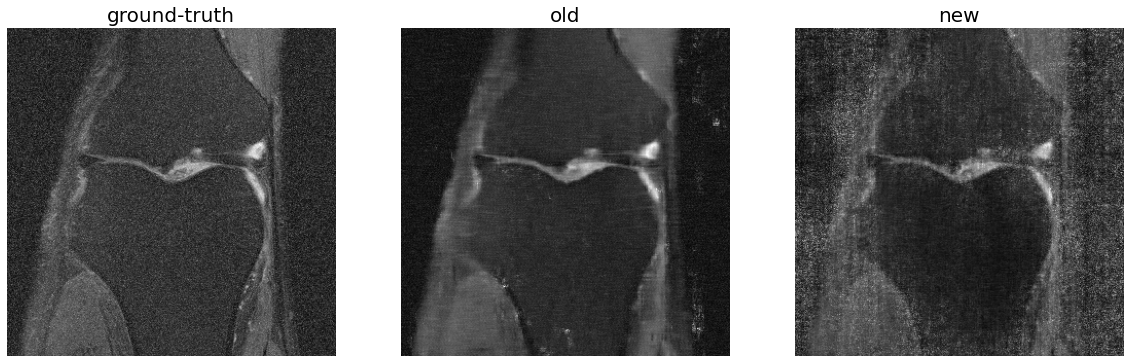

1000007
0.40511978922564235 23.931084358771194
0.24372434100563353 19.6352756897926


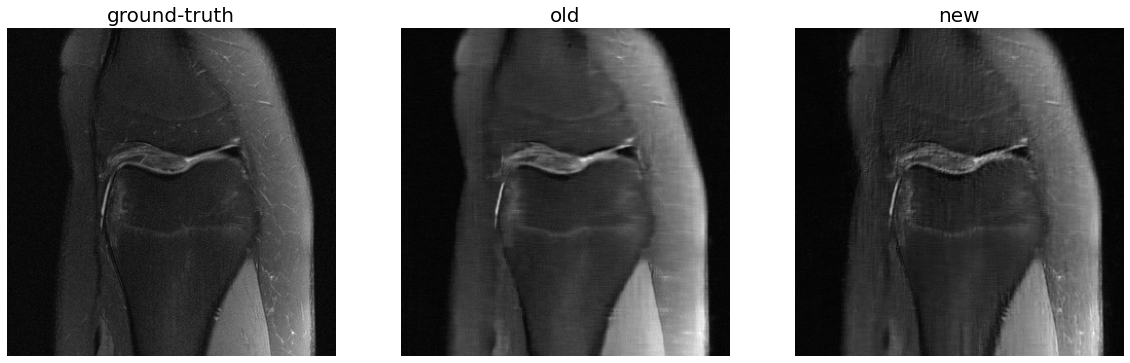

1000273
0.7516028564659959 30.837173954257665
0.7603502066727859 31.526079050724384


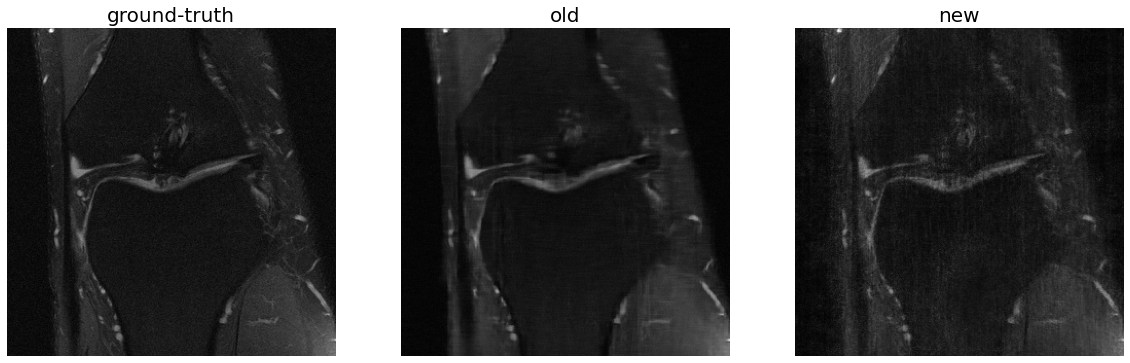

1000325
0.7638936926923392 32.14250682497399
0.6582776857846315 30.27927497164029


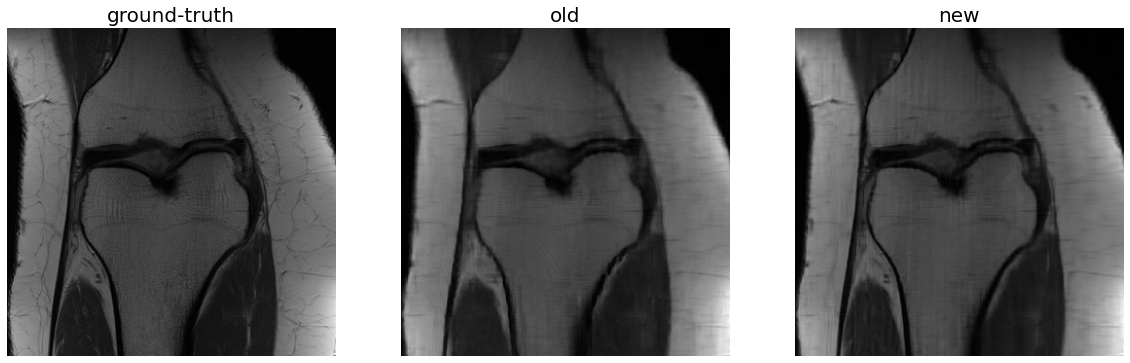

1000464
0.8420059564300316 32.622498328861205
0.8709488812249172 34.6582691779493


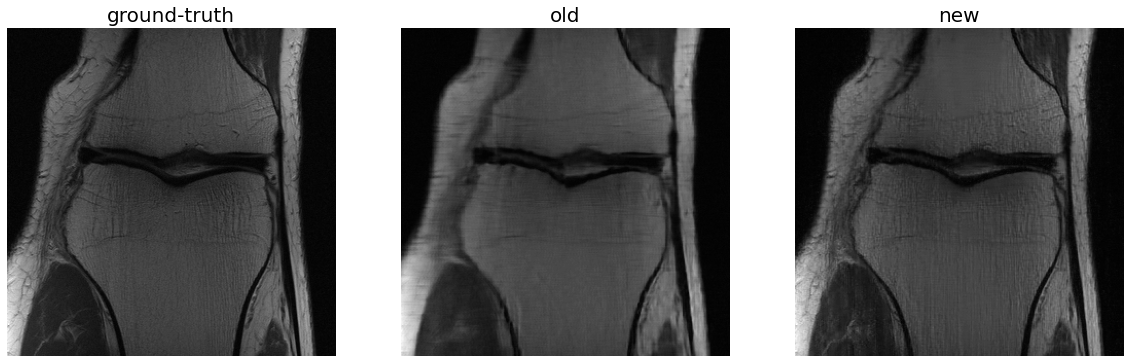

1000537
0.797108998684401 30.98192990388204
0.8246742740956695 32.92192389599956


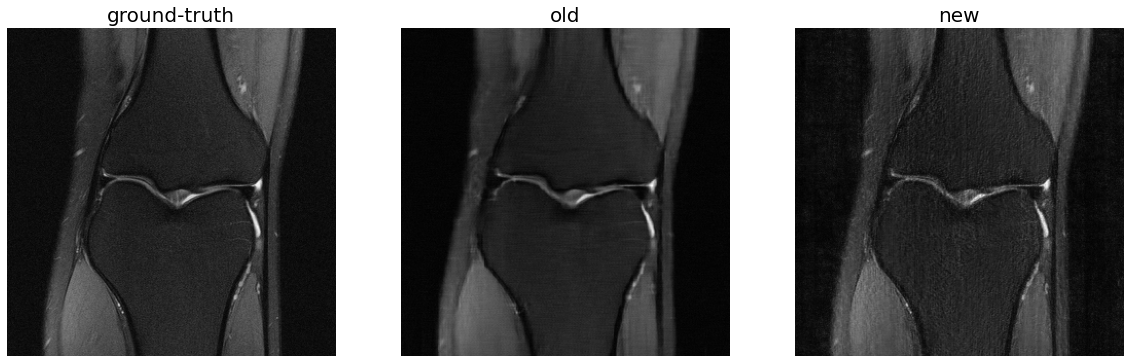

1000818
0.7875588336795045 32.069665854851095
0.6627600498044031 30.215795067284773


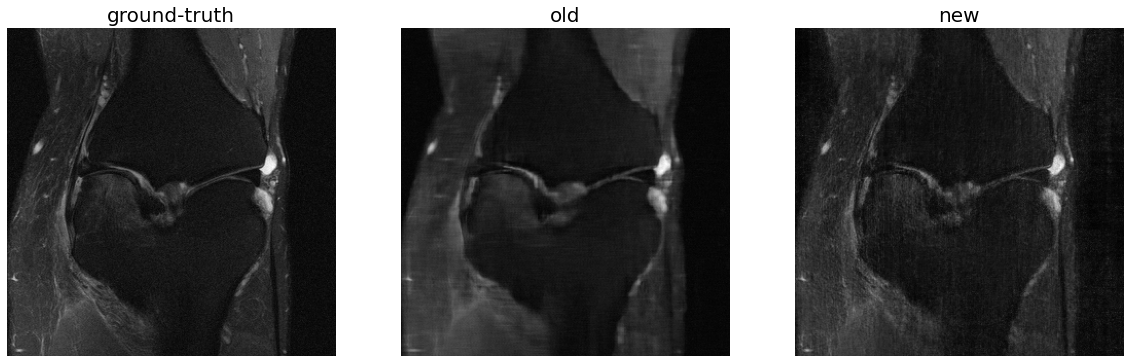

1001140
0.753169265857074 30.993035240057097
0.6565536469932362 29.931067445591637


In [68]:
ssim_n_list, ssim_o_list = [], []
psnr_n_list, psnr_o_list = [], []

for f in files_n_dc[:7]:
    
    vid_key = f.split('_')[0]
    
    arr_n = np.load(path_n + f)
    arr_o = np.load('{}{}_iter10000_alpha0.npy'.format(path_o, vid_key))
    arr_gt = np.load('{}{}_gt.npy'.format(path_n, vid_key))
    
    plot_list([arr_gt, arr_o, arr_n])
    
    _, _, ssim_n, psnr_n = calc_metrics(arr_n, arr_gt)
    _, _, ssim_o, psnr_o = calc_metrics(arr_o, arr_gt)
    ssim_n_list.append(ssim_n), psnr_n_list.append(psnr_n)
    ssim_o_list.append(ssim_o), psnr_o_list.append(psnr_o)
    
    print(vid_key)
    print(ssim_o, psnr_o)
    print(ssim_n, psnr_n)
    
ssim_n_list = np.asarray(ssim_n_list)
ssim_o_list = np.asarray(ssim_o_list)
psnr_n_list = np.asarray(psnr_n_list)
psnr_o_list = np.asarray(psnr_o_list)